In [7]:
import pytesseract
from PIL import Image
from auxiliary.measure_ocr_quality import measure_ocr_quality

In [35]:
import re
import os
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [9]:
def post_correct_text(ocr_output):
    cleaner_output = re.sub(r'(\w)<(\w)', '\\1ch\\2', ocr_output)
    cleaner_output = re.sub(r'(\w)5(\w)', '\\1s\\2', cleaner_output)
    cleaner_output = re.sub(r'\bv(m|nd)\b', 'u\\1', cleaner_output)
    cleaner_output = re.sub(r'\bfie\b', 'sie', cleaner_output)
    cleaner_output = cleaner_output.replace('ſ','s')
    cleaner_output = cleaner_output.replace('\n',' ')
    return cleaner_output

In [10]:
# 🚀 get the image to process in Colab
image_path = r"assets\images\grippe.jpeg"
img = Image.open(image_path)

In [11]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
os.environ["TESSDATA_PREFIX"] = r"C:\Program Files\Tesseract-OCR\tessdata"

In [12]:
ocr_output = pytesseract.image_to_string(img, lang='deu_latf')
print(ocr_output)

Zie Grippe wüfel weiter

Zunahme der ſchweren Fälle in Berlin.

Die Zahl der Grippefälle iſt in den letzten
beider Tagen auch in Groß-Berlin noH
erfblih zefitiegen. Die Worenhäuſer und ſon-
Haen aroßen GerſHäfte, die Krirgs- und die pri«
n Betriebe lagen, daß übermäig viele An«

: fich 5cben kren? melden miüen,-und an:
; ew Loſt und 5ei der Straßenbahn iſt der
ſoz der Grippekranken bedeuten) g&



In [13]:
ocr_output_corr = post_correct_text(ocr_output)
print(ocr_output_corr)

Zie Grippe wüfel weiter  Zunahme der schweren Fälle in Berlin.  Die Zahl der Grippefälle ist in den letzten beider Tagen auch in Groß-Berlin noH erfblih zefitiegen. Die Worenhäuser und son- Haen aroßen GersHäfte, die Krirgs- und die pri« n Betriebe lagen, daß übermäig viele An«  : fich 5cben kren? melden miüen,-und an: ; ew Lost und 5ei der Straßenbahn ist der soz der Grippekranken bedeuten) g& 


## Improvement

### Original (uncorrected) OCR result

In [24]:
ground_truth = 'Die Grippe wütet weiter. Zunahme der schweren Fälle in Berlin. Die Zahl der Grippefälle ist in den letzten Tagen auch in Groß-Berlin noch erheblich gestiegen. Die Warenhäuser und sonstigen großen Geschäfte, die Kriegs- und die privaten Betriebe klagen, daß übermäßig viele Angestellte sich haben krank melden müssen und auch bei der Post und bei der Straßenbahn ist der Prozentsatz der Grippekranken deutlich gestiegen.'

In [25]:
precision, recall, f_score = measure_ocr_quality(ocr_output, ground_truth)

In [26]:
print(f'Precision: {round(precision, 4)}\nRecall: {round(recall, 4)}\nF1-score: {round(f_score, 4)}')

Precision: 0.79
Recall: 0.8317
F1-score: 0.8103


### Corrected OCR result

In [29]:
Precision, Recall, f1_score = measure_ocr_quality(ocr_output_corr, ground_truth)

In [30]:
print(f'Precision: {round(Precision, 4)}\nRecall: {round(Recall, 4)}\nF1-score: {round(f1_score, 4)}')

Precision: 0.8162
Recall: 0.8593
F1-score: 0.8372


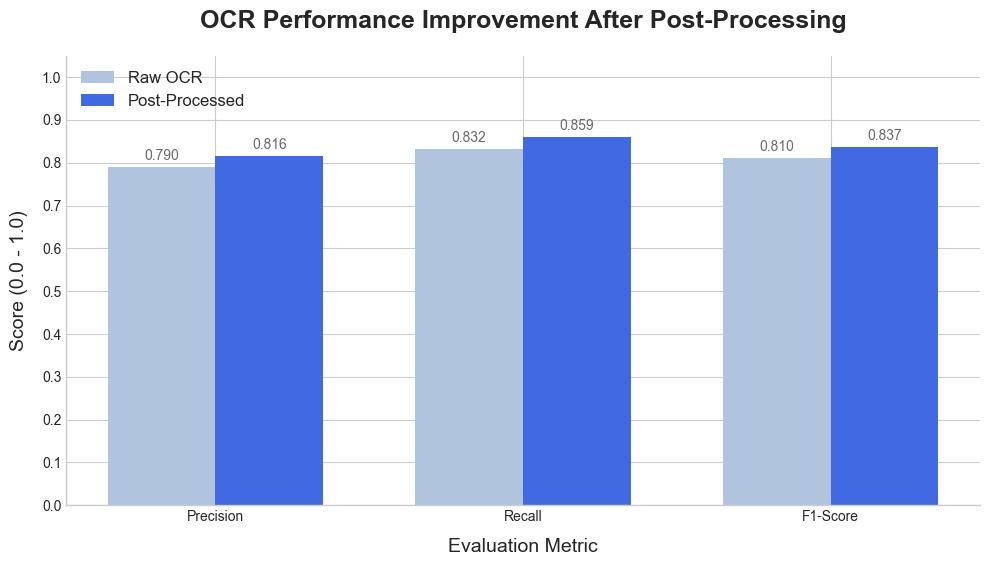

In [34]:
##(Raw OCR)
raw_scores = [precision, recall, f_score]

# "After" values (Post-Processing)
processed_scores = [Precision, Recall, f1_score]
# -----------------------------

# Define the labels for the metrics
metrics = ['Precision', 'Recall', 'F1-Score']

# Set the position of the bars on the X-axis
x = np.arange(len(metrics))  
width = 0.35  # the width of the bars

# --- Create the Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for "Raw OCR"
rects1 = ax.bar(x - width/2, 
                raw_scores, 
                width, 
                label='Raw OCR', 
                color='lightsteelblue')

# Plot the bars for "Post-Processed"
rects2 = ax.bar(x + width/2, 
                processed_scores, 
                width, 
                label='Post-Processed', 
                color='royalblue')

# --- Add Labels, Title, and Legend ---
ax.set_title('OCR Performance Improvement After Post-Processing',
             fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('Score (0.0 - 1.0)', fontsize=14, labelpad=10)
ax.set_xlabel('Evaluation Metric', fontsize=14, labelpad=10)

# Set the X-axis tick labels
ax.set_xticks(x)
ax.set_xticklabels(metrics)

# Set Y-axis limit and ticks
ax.set_ylim(0, 1.05)
ax.set_yticks(np.arange(0, 1.1, 0.1))

# Add a legend to explain the colors
ax.legend(fontsize=12, loc='upper left')

# --- Add Data Labels ---
# Function to add labels on top of bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}', # Format to 3 decimal places
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10,
                    color='dimgray')

add_labels(rects1)
add_labels(rects2)

# --- Clean up Spines ---
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [39]:
pathtxt = Path('data/txt')

for file in tqdm(pathtxt.iterdir()):
    if file.suffix == '.txt':
        try:
            text = file.read_text(encoding='utf-8')
            #text = file.read_text()
        except UnicodeDecodeError:
            # Fallback: ignore invalid characters
            text = file.read_text(encoding='utf-8', errors='ignore')
            
        corrected = post_correct_text(text)
        #file.write_text(corrected)
        file.write_text(corrected, encoding='utf-8')

105it [00:02, 46.60it/s]
